In [5]:
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import bilby
import corner
import numpy as np
import vitamin
from vitamin import vitamin_parser

module 'basemap' is not installed
Skyplotting functionality is automatically disabled.


In [6]:
%matplotlib inline

# this is how the priors would work

In [3]:
maxlogvar = np.log(np.nan_to_num(np.float32(np.inf)))

In [3]:
def mass_sample(num_samples, bounds = [10,80]):
    scale = bounds[1] - bounds[0]
    unif_1 = tfp.distributions.Uniform(0,1)
    m1 = tf.sqrt(unif_1.sample(num_samples))
    
    unif_2 = tfp.distributions.Uniform(0,m1)
    m2 = unif_2.sample()
    return tf.concat([[m1*scale + bounds[0]],[m2*scale + bounds[0]]], axis = 0)

In [4]:
def mass_post(m1,m2, bounds):
    output = tf.ones(len(m1))/((bounds[1] - bounds[0])**2)
    mass_mask = tf.greater(m2, m1) | tf.less(m1, bounds[0]) | tf.less(m2, bounds[0]) | tf.greater(m1, bounds[1]) | tf.greater(m2, bounds[1])
    infs =  tf.multiply(tf.ones_like(output), tf.constant(-np.inf, dtype=tf.float32))
    output = tf.where(mass_mask, infs, output)
    return output

In [6]:
def mass_throw_away(num_samples, bounds = [10,80]):
    scale = bounds[1] - bounds[0]
    unif_1 = tfp.distributions.Uniform(0,1)
    unif_2 = tfp.distributions.Uniform(0,1)
    samples = []
    for i in range(num_samples):
        m2 = unif_1.sample()
        m1 = unif_2.sample()
        while m1 < m2:
            m2 = unif_1.sample()
            m1 = unif_2.sample()
        
        samples.append([m1*scale + bounds[0],m2*scale + bounds[0]])
    return samples

In [7]:
masses = mass_sample(15000).numpy()

In [8]:
masses2 = mass_throw_away(5000)

In [9]:
bilby_prior = bilby.gw.prior.BBHPriorDict()

03:01 bilby INFO    : No prior given, using default BBH priors in /home/joseph.bayley/.local/lib/python3.7/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


In [10]:
bilby_prior = bilby.gw.prior.BBHPriorDict()
bilby_prior['mass_ratio'] = bilby.gw.prior.Constraint(minimum=0.125, maximum=1, name='mass_ratio', latex_label='$q$', unit=None)
bilby_prior['chirp_mass'] = bilby.gw.prior.Constraint(minimum=10, maximum=100, name='chirp_mass', latex_label='$q$', unit=None)
bilby_prior['mass_1'] = bilby.gw.prior.Uniform(name='mass_1', minimum=10, maximum=80,unit='$M_{\odot}$')
bilby_prior['mass_2'] = bilby.gw.prior.Uniform(name='mass_2', minimum=10, maximum=80,unit='$M_{\odot}$')

In [18]:
bilby_prior.keys()

dict_keys(['mass_1', 'mass_2', 'mass_ratio', 'chirp_mass', 'luminosity_distance', 'dec', 'ra', 'theta_jn', 'psi', 'phase', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl'])

In [11]:
bilby_samp = bilby_prior.sample(15000)

In [14]:
bilby_masses = np.array([bilby_samp["mass_1"], bilby_samp["mass_2"]]).T

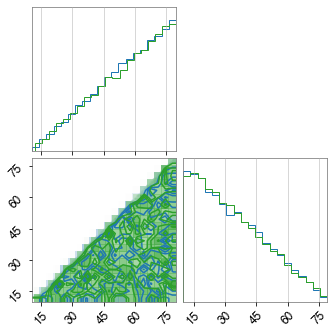

In [15]:
fig1 = corner.corner(masses.T, color = "C0")
#fig1 = corner.corner(np.array(masses2), fig=fig1, color = "C1")
fig1 = corner.corner(bilby_masses, fig=fig1, color = "C2")

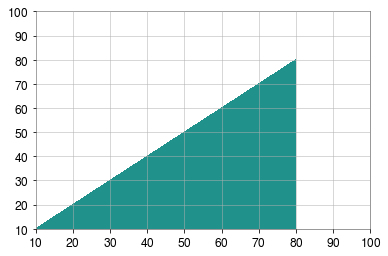

In [258]:
fig, ax = plt.subplots()
x = np.linspace(10,100,100)
X,Y = np.meshgrid(x,x)
theo_post = mass_post(X.ravel(),Y.ravel(), bounds = [10,80]).numpy()
ax.contourf(X, Y, theo_post.reshape(len(x), len(x)))

In [20]:
bilby_mass_ratios = np.array([bilby_samp["mass_1"]/bilby_samp["mass_2"], bilby_samp["mass_1"] + bilby_samp["mass_2"]]).T

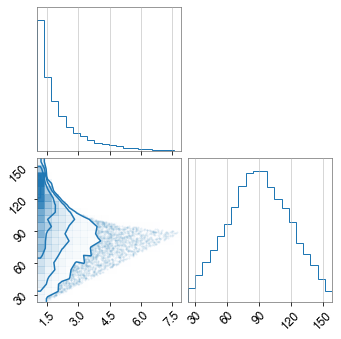

In [22]:
fig1 = corner.corner(bilby_mass_ratios, color = "C0")

In [3]:
bilby_prior = bilby.gw.prior.BBHPriorDict()

02:33 bilby INFO    : No prior given, using default BBH priors in /home/joseph.bayley/.local/lib/python3.7/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


In [7]:
bilby_samp = bilby_prior.sample(15000)

In [11]:
bilby_chirp_symm = np.array([bilby_samp["chirp_mass"], bilby_samp["mass_ratio"]]).T

In [17]:
bilby_prior

{'mass_1': Constraint(minimum=5, maximum=100, name='mass_1', latex_label='$m_1$', unit=None),
 'mass_2': Constraint(minimum=5, maximum=100, name='mass_2', latex_label='$m_2$', unit=None),
 'mass_ratio': Uniform(minimum=0.125, maximum=1, name='mass_ratio', latex_label='$q$', unit=None, boundary=None),
 'chirp_mass': Uniform(minimum=25, maximum=100, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, boundary=None),
 'luminosity_distance': UniformSourceFrame(minimum=100.0, maximum=5000.0, cosmology=FlatLambdaCDM(name="Planck15", H0=67.7 km / (Mpc s), Om0=0.307, Tcmb0=2.725 K, Neff=3.05, m_nu=[0.   0.   0.06] eV, Ob0=0.0486), name='luminosity_distance', latex_label='$d_L$', unit=Unit("Mpc"), boundary=None),
 'dec': Cosine(minimum=-1.5707963267948966, maximum=1.5707963267948966, name='dec', latex_label='$\\mathrm{DEC}$', unit=None, boundary=None),
 'ra': Uniform(minimum=0, maximum=6.283185307179586, name='ra', latex_label='$\\mathrm{RA}$', unit=None, boundary='periodic'),
 'theta_j

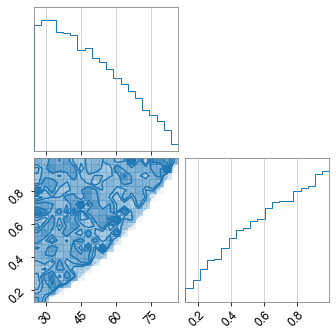

In [9]:
fig1 = corner.corner(bilby_chirp_symm, color = "C0")

In [69]:
bilby_prior2 = bilby.gw.prior.BBHPriorDict()
bilby_prior2['chirp_mass'] =  bilby.prior.Uniform(minimum=10, maximum=1400, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, boundary=None)
bilby_prior2['mass_1'] = bilby.prior.Constraint(minimum=5, maximum=100, name='mass_1', latex_label='$m_1$', unit=None)
bilby_prior2['mass_2'] = bilby.prior.Constraint(minimum=5, maximum=100, name='mass_1', latex_label='$m_1$', unit=None)
bilby_samp2 = bilby_prior2.sample(15000)

03:01 bilby INFO    : No prior given, using default BBH priors in /home/joseph.bayley/.local/lib/python3.7/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


In [70]:
bilby_chirp_symm2 = np.array([bilby_samp2["chirp_mass"], bilby_samp2["mass_ratio"]]).T

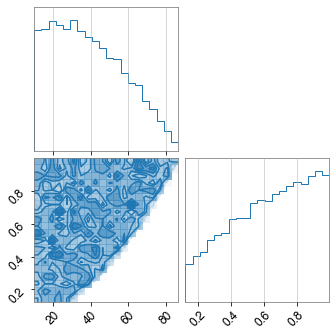

In [71]:
fig1 = corner.corner(bilby_chirp_symm2, color = "C0")

In [72]:
def chirpm(m1,m2):
    return (m1*m2)**(3/5)/((m1 + m2)**(-1/5))
def massr(m1,m2):
    return m1/m2

In [82]:
ms = np.linspace(0,50,100)

In [83]:
mrs = np.linspace(0,1,100)
cms = chirpm(ms,ms*mrs)

/home/joseph.bayley/.conda/envs/vitc_newkeras/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in power
  


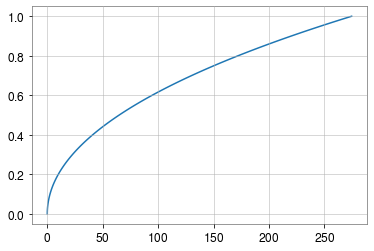

In [84]:
fig, ax = plt.subplots()
ax.plot(cms, mrs)

# for output posteriors

In [35]:
mean_mass_r2 = tf.cast(tf.expand_dims(tf.linspace([0,0],[1,1],1000, axis = 1), 0), dtype=tf.float32)
logvar_mass_r2 = tf.cast(tf.expand_dims(tf.linspace([-10,-10],[0,0],1000, axis = 1), 0), dtype=tf.float32)
m1,m2 = tf.split(mean_mass_r2, 2, axis = 1)
lv1,lv2 = tf.split(logvar_mass_r2, 2, axis = 1)

In [ ]:
class Truncated_2D():
    
    def __init__(self, mean, var, a , b):
        
        
        
        self._big_phi_a = self._big_phi(self.a)
        self._big_phi_b = self._big_phi(self.b)
        self._Z = (self._big_phi_b - self._big_phi_a).clamp_min(eps)

In [288]:
bounds = [0,1]

In [24]:
def trunc_gauss_conditional(m1, lv1, m2, lv2, p1, p2):
    tmvn_mass1_r2 = tfp.distributions.TruncatedNormal(
                    loc=tf.cast(m1,dtype=tf.float32),
                    scale=tf.cast(tf.sqrt(tf.exp(lv1)),dtype=tf.float32),
                    low=-10.0 + 1*10.0, high=1.0 + 10.0 - 1*10.0)

    tmvn_mass2_r2 = tfp.distributions.TruncatedNormal(
                    loc=tf.cast(m2,dtype=tf.float32),
                    scale=tf.cast(tf.sqrt(tf.exp(lv2)),dtype=tf.float32),
                    low=-10.0 + 1*10.0, high=p1 + 10.0 - 1*10.0)
    
    return tmvn_mass1_r2.log_prob(p1) + tmvn_mass2_r2.log_prob(p2)

In [9]:
m1,m2 = tf.split(mean_mass_r2, 2, axis = 1)

In [289]:
mass_mask = tf.greater(m2, m1) | tf.less(m1, bounds[0]) | tf.less(m2, bounds[0]) | tf.greater(m1, bounds[1]) | tf.greater(m2, bounds[1])

In [301]:
mass_log_prob = tmvn_mass_r2.log_prob(mean_mass_r2) + tf.constant(np.log(2),dtype=tf.float32)

In [302]:
mass_log_prob = tf.where(mass_log_prob, infs, output)

<tf.Tensor: shape=(1, 2, 10), dtype=float32, numpy=
array([[[5.4673557 , 4.218653  , 3.6630974 , 3.107542  ,
         2.5519862 , 1.9964517 , 1.4806607 , 1.1849303 ,
         0.99118596, 0.84907097],
        [5.4673557 , 4.218653  , 3.6630974 , 3.107542  ,
         2.5519862 , 1.9964517 , 1.4806607 , 1.1849303 ,
         0.99118596, 0.849071  ]]], dtype=float32)>

In [28]:
out_prob = trunc_gauss_conditional(mean_mass_r2, logvar_mass_r2, mean_mass_r2, logvar_mass_r2, mean_mass_r2, mean_mass_r2)

ValueError: x and y can be no greater than 2D, but have shapes (1,) and (1, 2, 10)

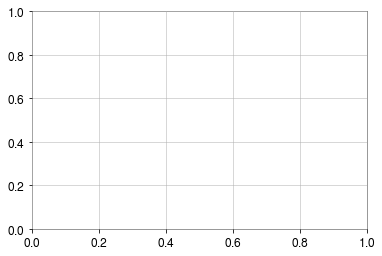

In [29]:
fig, ax = plt.subplots()
ax.plot(out_prob)

In [31]:
mean_mass_r2 = tf.cast(tf.expand_dims(tf.linspace([0.9,0.9],[0.9,0.9],1000, axis = 1), 0), dtype=tf.float32)
logvar_mass_r2 = tf.cast(tf.expand_dims(tf.linspace([-1,-10],[0,0],1000, axis = 1), 0), dtype=tf.float32)
m1,m2 = tf.split(mean_mass_r2, 2, axis = 1)
lv1,lv2 = tf.split(logvar_mass_r2, 2, axis = 1)

In [36]:
tmvn_mass1_r2 = tfp.distributions.TruncatedNormal(
                    loc=tf.cast(mean_mass_r2,dtype=tf.float32),
                    scale=tf.cast(tf.sqrt(tf.exp(logvar_mass_r2)),dtype=tf.float32),
                    low=-10.0 + 1*10.0, high=1.0 + 10.0 - 1*10.0)

In [37]:
tmvn_mass1_r2.sample()

<tf.Tensor: shape=(1, 2, 1000), dtype=float32, numpy=
array([[[0.60668707, 0.5341557 , 0.6957475 , ..., 0.8488993 ,
         0.92496574, 0.61471   ],
        [0.8925711 , 0.903577  , 0.9002244 , ..., 0.2401663 ,
         0.57586026, 0.795757  ]]], dtype=float32)>

In [32]:
Root = tfp.distributions.JointDistributionCoroutine.Root 
def model():
    md1 = yield Root(tfp.distributions.TruncatedNormal(
                    loc=tf.cast(m1,dtype=tf.float32),
                    scale=tf.cast(tf.sqrt(tf.exp(lv1)),dtype=tf.float32),
                    low=0, high=1))

    md2 = yield tfp.distributions.TruncatedNormal(
                    loc=tf.cast(m2,dtype=tf.float32),
                    scale=tf.cast(tf.sqrt(tf.exp(lv2)),dtype=tf.float32),
                    low=0, high=md1)


In [33]:
joint = tfp.distributions.JointDistributionCoroutine(model)


In [34]:
x = joint.sample()

In [35]:
joint.log_prob(m1,m2)

<tf.Tensor: shape=(1, 1, 1000), dtype=float32, numpy=
array([[[5.0553346 , 5.050093  , 5.0448513 , ..., 0.3504637 ,
         0.34912837, 0.3478037 ]]], dtype=float32)>

In [41]:
tf.concat(x, axis = 1)

<tf.Tensor: shape=(1, 2, 1000), dtype=float32, numpy=
array([[[0.42983392, 0.48689687, 0.9270321 , ..., 0.43221748,
         0.49315047, 0.2825325 ],
        [0.4295839 , 0.4868681 , 0.8973866 , ..., 0.16268986,
         0.19988918, 0.2310242 ]]], dtype=float32)>

In [109]:
np.shape(np.array(x)[:,0,0,:])

(2, 1000)

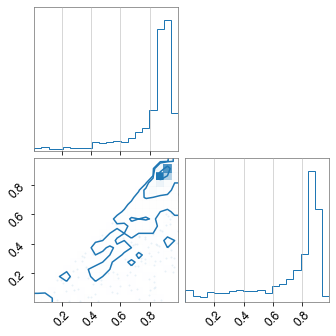

In [110]:
fig1 = corner.corner(np.array(x)[:,0,0,:].T, color = "C0")

# Trianguler distribution sampling

In [3]:
un = tfp.distributions.Uniform(0,1)

use the cdf of a triangle distribution (between 0 and 1)
PDF:
\begin{equation}
f(x) = 2x
\end{equation}
CDF:
\begin{equation}
F(x) = x^2
\end{equation}

In [4]:
smps = tf.sqrt(un.sample(5000).numpy())

(array([  57.,  157.,  266.,  329.,  443.,  551.,  610.,  718.,
         852., 1017.]),
 array([0.00269662, 0.10241976, 0.2021429 , 0.30186602,
        0.40158918, 0.5013123 , 0.6010355 , 0.7007586 ,
        0.80048174, 0.90020484, 0.999928  ], dtype=float32),
 <BarContainer object of 10 artists>)

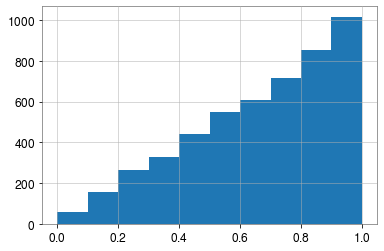

In [5]:
fig, ax = plt.subplots()
ax.hist(smps)

# mass ratio and chirp mass

In [1]:
def m1m2_to_chirpmassq(m1,m2):
    chirp_mass = ((m1*m2)**(3./5))/((m1 + m2)**(1./5))
    q = m2/m1
    return chirp_mass, q

def chirpmassq_to_m1m2(chirp_mass, q):
    m1 = chirp_mass*((1+q)/(q**3))**(1./5)
    m2 = m1*q
    return m1,m2

In [3]:
bilby_prior = bilby.gw.prior.BBHPriorDict()
bilby_prior['mass_ratio'] = bilby.gw.prior.Constraint(minimum=0.125, maximum=1, name='mass_ratio', latex_label='$q$', unit=None)
bilby_prior['chirp_mass'] = bilby.gw.prior.Constraint(minimum=10, maximum=100, name='chirp_mass', latex_label='$q$', unit=None)
bilby_prior['mass_1'] = bilby.gw.prior.Uniform(name='mass_1', minimum=10, maximum=100,unit='$M_{\odot}$')
bilby_prior['mass_2'] = bilby.gw.prior.Uniform(name='mass_2', minimum=10, maximum=100,unit='$M_{\odot}$')

01:10 bilby INFO    : No prior given, using default BBH priors in /home/joseph.bayley/.local/lib/python3.7/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


In [33]:
bilby_prior = bilby.gw.prior.BBHPriorDict()
bilby_prior['mass_1'] = bilby.gw.prior.Uniform(name='mass_1', minimum=10, maximum=100,unit='$M_{\odot}$')
bilby_prior['mass_2'] = bilby.gw.prior.Uniform(name='mass_2', minimum=10, maximum=100,unit='$M_{\odot}$')

07:16 bilby INFO    : No prior given, using default BBH priors in /home/joseph.bayley/.local/lib/python3.7/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


In [34]:
bilby_samp = bilby_prior.sample(1)

In [37]:
cp, ak = bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters(bilby_samp)

In [38]:
for i,j in bilby_samp.items():
    print(i,j[0])

mass_1 62.63724313534102
mass_2 69.85908782854881
mass_ratio 0.23569579706345747
chirp_mass 58.584485297002715
luminosity_distance 3808.1909722930172
dec -0.707717593900221
ra 2.5565548863712055
theta_jn 0.9403066303111198
psi 0.7085757195920851
phase 3.1544035325581485
a_1 0.8605979496865239
a_2 0.8076576709965305
tilt_1 1.20494726750142
tilt_2 2.128024391879961
phi_12 4.84842835413301
phi_jl 2.8444022513749356


In [22]:
bilby_samp

{'mass_1': array([92.92234782]),
 'mass_2': array([20.49660692]),
 'luminosity_distance': array([2944.04935622]),
 'dec': array([0.89571068]),
 'ra': array([5.56692282]),
 'theta_jn': array([2.02548505]),
 'psi': array([0.71073209]),
 'phase': array([1.61360909]),
 'a_1': array([0.85730285]),
 'a_2': array([0.60311516]),
 'tilt_1': array([0.65391204]),
 'tilt_2': array([1.97297163]),
 'phi_12': array([2.37531808]),
 'phi_jl': array([5.34114284])}

In [20]:
for i in range(30):
    parlist = []
    bilby_samp = bilby_prior.sample(1)
    cp, ak = bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters(bilby_samp)
    for i,j in bilby_samp.items():
        parlist.append(i)
    print(parlist)

['mass_1', 'mass_2', 'luminosity_distance', 'dec', 'ra', 'theta_jn', 'psi', 'phase', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl']
['mass_1', 'mass_2', 'luminosity_distance', 'dec', 'ra', 'theta_jn', 'psi', 'phase', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl']
['mass_1', 'mass_2', 'luminosity_distance', 'dec', 'ra', 'theta_jn', 'psi', 'phase', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl']
['mass_1', 'mass_2', 'luminosity_distance', 'dec', 'ra', 'theta_jn', 'psi', 'phase', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl']
['mass_1', 'mass_2', 'luminosity_distance', 'dec', 'ra', 'theta_jn', 'psi', 'phase', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl']
['mass_1', 'mass_2', 'luminosity_distance', 'dec', 'ra', 'theta_jn', 'psi', 'phase', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl']
['mass_1', 'mass_2', 'luminosity_distance', 'dec', 'ra', 'theta_jn', 'psi', 'phase', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl']
['mass_1', 'mass_2', 'lumin

In [25]:
bilby_masses = np.array([bilby_samp["mass_1"], bilby_samp["mass_2"]]).T

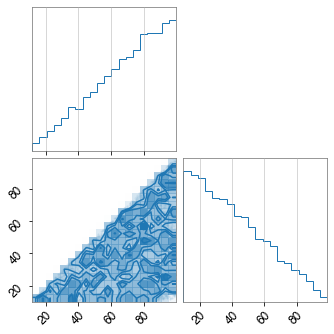

In [26]:
fig1 = corner.corner(bilby_masses, color = "C0")

In [31]:
bilby_mass_ratios = np.array(m1m2_to_chirpmassq(bilby_samp["mass_1"], bilby_samp["mass_2"])).T

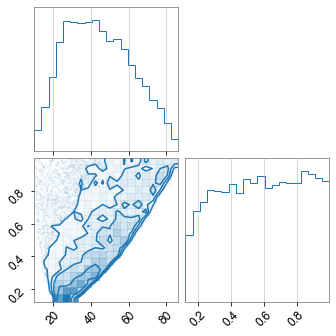

In [32]:
fig1 = corner.corner(bilby_mass_ratios, color = "C0")

In [30]:
def Mconstrainm1(q_norm, m):
    q_max = 1
    q_min = 0.125
    q = q_norm*(q_max - q_min) + q_min
    M_min = 10
    M_max = 100
    num = (q*m*m)**(3./5.)
    den = (m*(1 + q))**(1./5.)
    return (num/den - M_min)/(M_max - M_min)

def Mconstrainm2(q_norm, m):
    q_max = 1
    q_min = 0.125
    q = q_norm*(q_max - q_min) + q_min
    M_min = 10
    M_max = 100
    num = ((1/q)*m*m)**(3./5.)
    den = (m*(1 + 1/q))**(1./5.)
    return (num/den - M_min)/(M_max - M_min)


def jointchirpq(mq,mcm,lvq,lvcm, minm = 10, maxm = 100):
    joint2 = tfp.distributions.JointDistributionSequential([
        tfp.distributions.TruncatedNormal(
        loc=tf.cast(mq,dtype=tf.float32),
        scale=tf.cast(tf.sqrt(tf.exp(lvq)),dtype=tf.float32),
        low=0, high=1),
        lambda b0: tfp.distributions.TruncatedNormal(
                        loc=tf.cast(mcm,dtype=tf.float32),
                        scale=tf.cast(tf.sqrt(tf.exp(lvcm)),dtype=tf.float32),
                        low=Mconstrainm2(b0, minm), high=Mconstrainm1(b0, maxm)),
    ])
    return joint2

In [232]:
Mconstrain(0.125,10)

22.43910290892398

In [233]:
(100*100)**(3/5)/(100 + 100)**(1/5)

87.0550563296124

In [31]:
maxlogvar = tf.exp(-maxlogvar+1)

In [37]:
trn = tfp.distributions.TruncatedNormal(
        loc=tf.cast(0.5,dtype=tf.float32),
        scale=tf.cast(1e-6 + tf.sqrt(maxlogvar),dtype=tf.float32),
        low=0, high=1)

In [38]:
tsamp = trn.sample(100)

In [39]:
trn.log_prob(0.1)

<tf.Tensor: shape=(), dtype=float32, numpy=-80000000000.0>

In [34]:
consch = tfp.distributions.TruncatedNormal(
                        loc=tf.cast(0.5,dtype=tf.float32),
                        scale=tf.cast(tf.sqrt(maxlogvar),dtype=tf.float32),
                        low=Mconstrainm2(tsamp, 10), high=Mconstrainm1(tsamp, 100))

In [27]:
consch.sample(100)

<tf.Tensor: shape=(100, 100), dtype=float32, numpy=
array([[0.03079805, 0.28201622, 0.505483  , ..., 0.27925545,
        0.3916736 , 0.1841344 ],
       [0.58692384, 0.29655632, 0.28444815, ..., 0.5392979 ,
        0.32022965, 0.15760541],
       [0.5762502 , 0.07670006, 0.502749  , ..., 0.3108927 ,
        0.4089164 , 0.11854848],
       ...,
       [0.26267737, 0.3113074 , 0.03906652, ..., 0.18612957,
        0.40740958, 0.12363487],
       [0.2673203 , 0.27767766, 0.13102818, ..., 0.26156285,
        0.3054794 , 0.11707455],
       [0.3375072 , 0.170584  , 0.54739547, ..., 0.34632158,
        0.42405704, 0.14448437]], dtype=float32)>

In [9]:
jcq = jointchirpq([0.5],[0.5],[maxlogvar],[maxlogvar])

In [29]:
samplescq = jcq.sample(1000)
#samplescq = tf.concat(samplescq, axis =1).numpy()

InvalidArgumentError: Invalid parameters [Op:StatelessParameterizedTruncatedNormal]

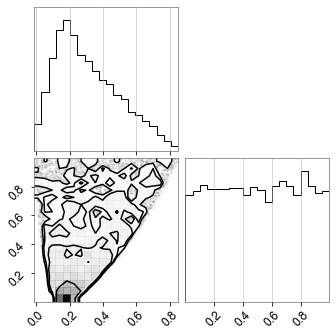

In [236]:
f1 = corner.corner(samplescq[:,(1,0)])

In [1]:
bilby_prior2 = bilby.gw.prior.BBHPriorDict()
bilby_prior2['mass_ratio'] = bilby.gw.prior.Uniform(minimum=0.125, maximum=1, name='mass_ratio', latex_label='$q$', unit=None)
bilby_prior2['chirp_mass'] = bilby.gw.prior.Uniform(minimum=10, maximum=100, name='chirp_mass', latex_label='$q$', unit=None)
bilby_prior2['mass_1'] = bilby.gw.prior.Constraint(name='mass_1', minimum=10, maximum=100,unit='$M_{\odot}$')
bilby_prior2['mass_2'] = bilby.gw.prior.Constraint(name='mass_2', minimum=10, maximum=100,unit='$M_{\odot}$')

NameError: name 'bilby' is not defined

In [216]:
bilby_prior2["mass_1"].minimum

10

In [237]:
bilby_samp2 = bilby_prior2.sample(10000)
bilby_masses2 = np.array([(bilby_samp2["chirp_mass"] - 10)/(100-10), (bilby_samp2["mass_ratio"] - 0.125)/(1- 0.125)]).T
#bilby_mass_ratios2 = np.array(m1m2_to_chirpmassq(bilby_samp2["mass_1"], bilby_samp2["mass_2"])).T

In [238]:
np.any(np.isinf(jcq.log_prob((bilby_samp2["mass_ratio"] - 0.125)/(1- 0.125), (bilby_samp2["chirp_mass"] - 10)/(100-10))))

False

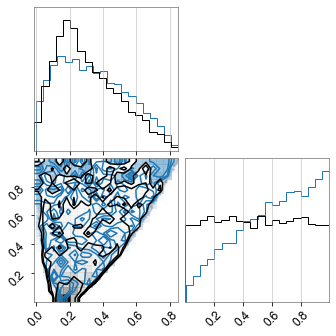

In [212]:
fig2 = corner.corner(bilby_masses2, color = "C0")
fig2 = corner.corner(samplescq[:,(1,0)], fig = fig2)

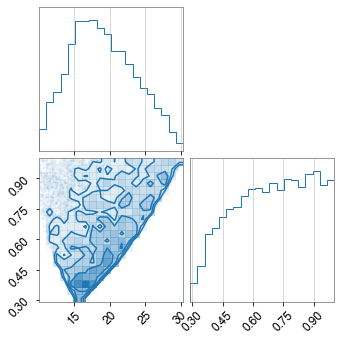

In [37]:
fig2r = corner.corner(bilby_mass_ratios2, color = "C0")

In [39]:
bilby_prior3 = bilby.gw.prior.BBHPriorDict()
bilby_prior3['mass_ratio'] = bilby.gw.prior.Constraint(minimum=0.125, maximum=0.4, name='mass_ratio', latex_label='$q$', unit=None)
bilby_prior3['chirp_mass'] = bilby.gw.prior.Constraint(minimum=10, maximum=100, name='chirp_mass', latex_label='$q$', unit=None)
bilby_prior3['mass_1'] = bilby.gw.prior.Uniform(name='mass_1', minimum=10, maximum=100,unit='$M_{\odot}$')
bilby_prior3['mass_2'] = bilby.gw.prior.Uniform(name='mass_2', minimum=10, maximum=100,unit='$M_{\odot}$')

01:47 bilby INFO    : No prior given, using default BBH priors in /home/joseph.bayley/.local/lib/python3.7/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


In [40]:
bilby_samp3 = bilby_prior3.sample(10000)
bilby_masses3 = np.array([bilby_samp3["mass_1"], bilby_samp3["mass_2"]]).T
bilby_mass_ratios3 = np.array(m1m2_to_chirpmassq(bilby_samp3["mass_1"], bilby_samp3["mass_2"])).T

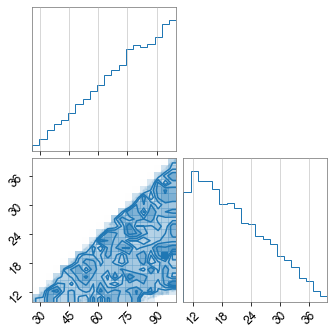

In [41]:
fig3 = corner.corner(bilby_masses3, color = "C0")

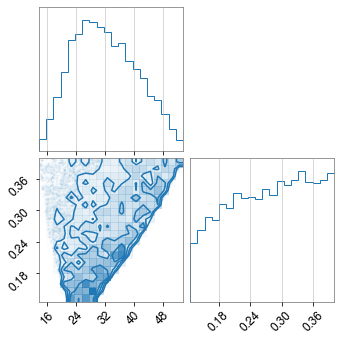

In [42]:
fig3r = corner.corner(bilby_mass_ratios3, color = "C0")

In [47]:
bilby_prior4 = bilby.gw.prior.BBHPriorDict()
bilby_prior4['mass_ratio'] = bilby.gw.prior.Constraint(minimum=0.125, maximum=1.0, name='mass_ratio', latex_label='$q$', unit=None)
bilby_prior4['chirp_mass'] = bilby.gw.prior.Constraint(minimum=10, maximum=100, name='chirp_mass', latex_label='$q$', unit=None)
bilby_prior4['mass_1'] = bilby.gw.prior.Uniform(name='mass_1', minimum=35, maximum=80,unit='$M_{\odot}$')
bilby_prior4['mass_2'] = bilby.gw.prior.Uniform(name='mass_2', minimum=35, maximum=80,unit='$M_{\odot}$')

01:50 bilby INFO    : No prior given, using default BBH priors in /home/joseph.bayley/.local/lib/python3.7/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


In [48]:
bilby_samp4 = bilby_prior4.sample(10000)
bilby_masses4 = np.array([bilby_samp4["mass_1"], bilby_samp4["mass_2"]]).T
bilby_mass_ratios4 = np.array(m1m2_to_chirpmassq(bilby_samp4["mass_1"], bilby_samp4["mass_2"])).T

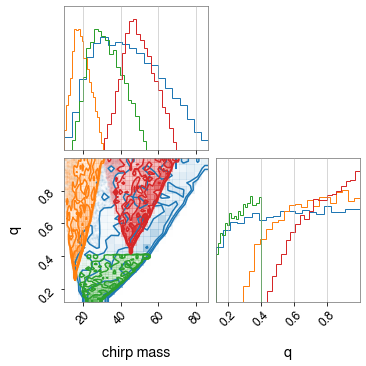

In [56]:
figmr = corner.corner(bilby_mass_ratios, color = "C0", labels = ["chirp mass", "q"])
figmr = corner.corner(bilby_mass_ratios2, color = "C1", fig = figmr)
figmr = corner.corner(bilby_mass_ratios3, color = "C2", fig = figmr)
figmr = corner.corner(bilby_mass_ratios4, color = "C3", fig = figmr)

In [57]:
figmr.savefig("./massratios.png")

## prior file test

In [30]:
from collections import OrderedDict

In [23]:
prior_file = "/home/joseph.bayley/public_html/CBC/vitamin_refactor_O4/vitamin_run1/bbh_prior.prior"

In [26]:
pd = bilby.gw.prior.BBHPriorDict(prior_file)

In [32]:
pd.sample()

{'mass_ratio': 0.5011140339008157,
 'chirp_mass': 38.64203630709584,
 'a_1': 0.8521366749725264,
 'a_2': 0.5300074933657929,
 'tilt_1': 2.0175030103667053,
 'tilt_2': 1.2629083552935318,
 'phi_12': 2.089930106077566,
 'phi_jl': 3.519558710895723,
 'luminosity_distance': 4125.065490557303,
 'dec': -1.3281703699393461,
 'ra': 0.15346597692635186,
 'theta_jn': 1.4207207279233813,
 'psi': 3.0464213368925006,
 'phase': 5.988110151616171}

In [31]:
OrderedDict(pd)

OrderedDict([('mass_ratio',
              Uniform(minimum=0.125, maximum=1, name='mass_ratio', latex_label='$q$', unit=None, boundary=None)),
             ('chirp_mass',
              Uniform(minimum=5, maximum=200, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, boundary=None)),
             ('mass_1',
              Constraint(minimum=10, maximum=100, name='mass_1', latex_label='$m_1$', unit=None)),
             ('mass_2',
              Constraint(minimum=10, maximum=100, name='mass_2', latex_label='$m_2$', unit=None)),
             ('a_1',
              Uniform(minimum=0, maximum=0.99, name='a_1', latex_label='$a_1$', unit=None, boundary=None)),
             ('a_2',
              Uniform(minimum=0, maximum=0.99, name='a_2', latex_label='$a_2$', unit=None, boundary=None)),
             ('tilt_1',
              Sine(minimum=0, maximum=3.141592653589793, name='tilt_1', latex_label='$\\theta_1$', unit=None, boundary=None)),
             ('tilt_2',
              Sine(minimum=0

In [7]:
class JointChirpmassMRM1M2:

    def __init__(self, pars, config):
        """                                                                                                                                
        Joint distribution for Chirpmass and symetric mas ratio                                                                            
        """
        self.name = "JointChirpmassMRM1M2"
        self.config = config
        self.pars = pars
        if self.pars[0] == "mass_2":
            self.order_flipped = True
        elif self.pars[0] == "mass_1":
            self.order_flipped = False

        self.num_pars = len(self.pars)
        if self.num_pars != 2:
            raise Exception("Please only use two variables for JointM1M2")
        self.num_outputs = [self.num_pars,self.num_pars]
        self.get_cost = self.cost_setup()
        self.sample = self.sample_setup()

    def Mconstrainm1(self, q_norm, m):
        """Contraint for the chirp mass based on maxmium mass of m1                                                                         
        """
        q = q_norm*(self.config["bounds"]["mass_ratio_max"] - self.config["bounds"]["mass_ratio_min"]) + self.config["bounds"]["mass_ratio_min"]
        num = (q*m*m)**(3./5.)
        den = (m*(1 + q))**(1./5.)
        chirpmass = num/den
        inds = tf.where(chirpmass > self.config["bounds"]["chirp_mass_max"])
        print(inds.shape)
        if inds.shape[0] is not None:
            updates = tf.ones(inds.shape[0], dtype=tf.float32)*np.float32(self.config["bounds"]["chirp_mass_max"])
            chirpmass = tf.tensor_scatter_nd_update(chirpmass, inds, updates)
        return (chirpmass - self.config["bounds"]["chirp_mass_min"])/(self.config["bounds"]["chirp_mass_max"] - self.config["bounds"]["chirp_mass_min"])

    def Mconstrainm2(self, q_norm, m):
        """Contraint for the chirp mass based on minimum mass of m2"""
        q = q_norm*(self.config["bounds"]["mass_ratio_max"] - self.config["bounds"]["mass_ratio_min"]) + self.config["bounds"]["mass_ratio_min"]
        num = ((1/q)*m*m)**(3./5.)
        den = (m*(1 + 1/q))**(1./5.)
        chirpmass = num/den
        inds = tf.where(chirpmass < self.config["bounds"]["chirp_mass_min"])
        print(inds.shape)
        if inds.shape[0] is not None:
            updates = tf.ones(inds.shape[0], dtype=tf.float32)*np.float32(self.config["bounds"]["chirp_mass_min"])
            chirpmass = tf.tensor_scatter_nd_update(chirpmass, inds, updates)
        return (chirpmass  - self.config["bounds"]["chirp_mass_min"])/(self.config["bounds"]["chirp_mass_max"] - self.config["bounds"]["chirp_mass_min"])
    
    def get_distribution(self, mean, logvar, ramp = 1.0):
        # this is not working yet                                                                                                           
        mean_q, mean_cm = tf.split(mean, num_or_size_splits=2, axis=1)
        logvarq, logvarcm = tf.split(logvar, num_or_size_splits=2, axis=1)

        joint = tfp.distributions.JointDistributionSequential([
            tfp.distributions.TruncatedNormal(
                loc=tf.cast(mean_q,dtype=tf.float32),
                scale=tf.cast(tf.sqrt(tf.exp(logvarq)),dtype=tf.float32),
                low=0, high=1),
            lambda b0: tfp.distributions.TruncatedNormal(
                loc=tf.cast(mean_cm,dtype=tf.float32),
                scale=tf.cast(tf.sqrt(tf.exp(logvarcm)),dtype=tf.float32),
                low=self.Mconstrainm2(b0, self.config["bounds"]["mass_2_min"]),
                high=self.Mconstrainm1(b0, self.config["bounds"]["mass_1_max"])),
        ])
        return joint

    def get_networks(self,logvar_activation="none"):
        # setup network for joint sitribution                                                                                               
        mean =  tf.keras.layers.Dense(2,activation='sigmoid', use_bias = True, name="{}_mean".format(self.name))
        logvar = tf.keras.layers.Dense(2,use_bias=True, name="{}_logvar".format(self.name),activation = logvar_activation)
        return mean, logvar
    
    def component_masses_to_chirpmass_massratio(self, normed_mass_1, normed_mass_2):
        """ Convert component masses to normalised chirp mass and mass ratio"""
        mass_1 = normed_mass_1*(self.config["bounds"]["mass_1_max"] - self.config["bounds"]["mass_1_min"]) + self.config["bounds"]["mass_1_min"]
        mass_2 = normed_mass_2*(self.config["bounds"]["mass_2_max"] - self.config["bounds"]["mass_2_min"]) + self.config["bounds"]["mass_2_min"]
        chirpmass, massratio = ((mass_1*mass_2)**(0.6))/((mass_1 + mass_2)**(0.2)), mass_2/mass_1
        normed_chirpmass = (chirpmass - self.config["bounds"]["chirp_mass_min"])/(self.config["bounds"]["chirp_mass_max"] - self.config["bounds"]["chirp_mass_min"])
        normed_massratio = (massratio - self.config["bounds"]["mass_ratio_min"])/(self.config["bounds"]["mass_ratio_max"] - self.config["bounds"]["mass_ratio_min"])
        return normed_massratio, normed_chirpmass

    def chirpmass_massratio_to_component_masses(self, chirpmass, massratio):
        """ Convert component masses to normalised chirp mass and mass ratio"""
        chirpmass = chirpmass*(self.config["bounds"]["chirp_mass_max"] - self.config["bounds"]["chirp_mass_min"]) + self.config["bounds"]["chirp_mass_min"]
        massratio = massratio*(self.config["bounds"]["mass_ratio_max"] - self.config["bounds"]["mass_ratio_min"]) + self.config["bounds"]["mass_ratio_min"]
        massratio = massratio
        total_mass = chirpmass*(1+massratio)**1.2/massratio**0.6
        mass_1 = total_mass/(1+massratio)
        mass_2 = mass_1*massratio
        normed_mass_1 = (mass_1 - self.config["bounds"]["mass_1_min"])/(self.config["bounds"]["mass_1_max"] - self.config["bounds"]["mass_1_min"])
        normed_mass_2 = (mass_2 - self.config["bounds"]["mass_2_min"])/(self.config["bounds"]["mass_2_max"] - self.config["bounds"]["mass_2_min"])
        return normed_mass_1, normed_mass_2
    
    def cost_setup(self):
        if self.order_flipped:
            def get_cost(dist, x):
                # reverse order of true parmaeters to estimate logprob                                                                      
                x2, x1 = tf.split(x, num_or_size_splits=2, axis=1)
                normed_massratio, normed_chirpmass = self.component_masses_to_chirpmass_massratio(x1,x2)
                #return -1.0*tf.reduce_mean(tf.reduce_sum(dist.log_prob(x1, x2),axis=1),axis=0)
                return x1,x2,massratio,chirpmass,dist.log_prob(normed_massratio, normed_chirpmass)
        else:
            def get_cost(dist, x):
                x1, x2 = tf.split(x, num_or_size_splits=2, axis=1)
                normed_massratio, normed_chirpmass = self.component_masses_to_chirpmass_massratio(x1,x2)
                #return -1.0*tf.reduce_mean(tf.reduce_sum(dist.log_prob(x1, x2),axis=1),axis=0)
                return x1,x2,normed_massratio,normed_chirpmass,dist.log_prob(normed_massratio, normed_chirpmass)

        return get_cost

    def sample_setup(self):
        if self.order_flipped:
            # reverse order of samples based on inputs                                                                                      
            def sample(dist, max_samples):
                # transpose amd squeeze to get [samples, parameters]                                                                        
                massratio, chirpmass =  tf.split(tf.squeeze(tf.transpose(dist.sample(), [1, 0, 2]), 2), num_or_size_splits=2, axis=1)
                mass_1, mass_2 = self.chirpmass_massratio_to_component_masses(chirpmass, massratio)
                return chirpmass, massratio,tf.concat([mass_1,mass_2], axis = 1)
        else:
            def sample(dist, max_samples):
                massratio, chirpmass =  tf.split(tf.squeeze(tf.transpose(dist.sample(), [1, 0, 2]), 2), num_or_size_splits=2, axis=1)
                mass_1, mass_2 = self.chirpmass_massratio_to_component_masses(chirpmass, massratio)
                return chirpmass, massratio, tf.concat([mass_1,mass_2], axis = 1)
        return sample

In [8]:
config = vitamin_parser.InputParser("~/public_html/CBC/vitamin_refactor_O4/vitamin_run3/config.ini")

05:25 bilby INFO    : No prior given, using default BBH priors in /home/joseph.bayley/.local/lib/python3.7/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


No prior file, using default prior


In [9]:
jcm = JointChirpmassMRM1M2(["mass_1", "mass_2"], config)

In [10]:
jcm.config["bounds"]

{'mass_1_max': 100,
 'mass_1_min': 5,
 'mass_2_max': 100,
 'mass_2_min': 5,
 'mass_ratio_max': 1,
 'mass_ratio_min': 0.125,
 'chirp_mass_max': 100,
 'chirp_mass_min': 25,
 'luminosity_distance_max': 5000.0,
 'luminosity_distance_min': 100.0,
 'dec_max': 1.5707963267948966,
 'dec_min': -1.5707963267948966,
 'ra_max': 6.283185307179586,
 'ra_min': 0,
 'theta_jn_max': 3.141592653589793,
 'theta_jn_min': 0,
 'psi_max': 3.141592653589793,
 'psi_min': 0,
 'phase_max': 6.283185307179586,
 'phase_min': 0,
 'a_1_max': 0.99,
 'a_1_min': 0,
 'a_2_max': 0.99,
 'a_2_min': 0,
 'tilt_1_max': 3.141592653589793,
 'tilt_1_min': 0,
 'tilt_2_max': 3.141592653589793,
 'tilt_2_min': 0,
 'phi_12_max': 6.283185307179586,
 'phi_12_min': 0,
 'phi_jl_max': 6.283185307179586,
 'phi_jl_min': 0,
 'geocent_time_max': 1325029268.35,
 'geocent_time_min': 1325029268.15}

In [249]:
qmean = 0.7
mrmean = 0.15
print(qmean*(jcm.config["bounds"]["mass_ratio_max"] - jcm.config["bounds"]["mass_ratio_min"]) + jcm.config["bounds"]["mass_ratio_min"])
print(mrmean*(jcm.config["bounds"]["chirp_mass_max"] - jcm.config["bounds"]["chirp_mass_min"]) + jcm.config["bounds"]["chirp_mass_min"])

0.7374999999999999
36.25


In [250]:
mean = tf.concat([tf.ones((10000,1))*qmean, tf.ones((10000,1))*mrmean], axis=1)
logvar = tf.concat([tf.ones((10000,1))*-1, tf.ones((10000,1))*-8], axis=1)

In [251]:
dist = jcm.get_distribution(mean, logvar)

In [252]:
chm,mr,smp = jcm.sample(dist, 1000)

(None, 2)
(None, 2)
(10000, 2)
(0, 2)


In [253]:
cmr = chm*(jcm.config["bounds"]["chirp_mass_max"] - jcm.config["bounds"]["chirp_mass_min"]) + jcm.config["bounds"]["chirp_mass_min"]
mrr = mr*(jcm.config["bounds"]["mass_ratio_max"] - jcm.config["bounds"]["mass_ratio_min"]) + jcm.config["bounds"]["mass_ratio_min"]
  
m1r = smp[:,:1]*(jcm.config["bounds"]["mass_1_max"] - jcm.config["bounds"]["mass_1_min"]) + jcm.config["bounds"]["mass_1_min"]
m2r = smp[:,1:]*(jcm.config["bounds"]["mass_2_max"] - jcm.config["bounds"]["mass_2_min"]) + jcm.config["bounds"]["mass_2_min"]
       

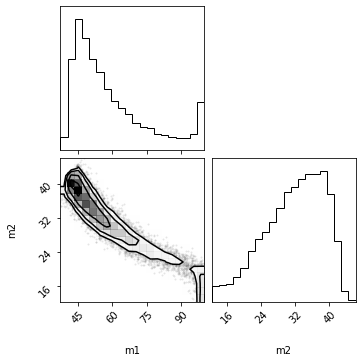

In [254]:
fg = corner.corner(np.concatenate([m1r,m2r],axis=1), labels = ["m1", "m2"])

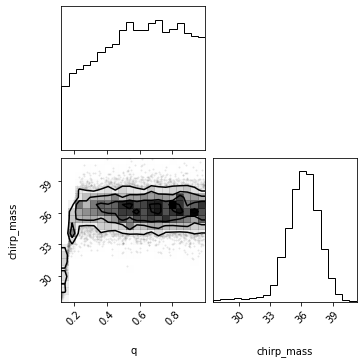

In [255]:
fg = corner.corner(np.concatenate([mrr,cmr],axis=1), labels = ["q", "chirp_mass"])

In [256]:
jcm.Mconstrainm2(tf.linspace(0.0,1.0,100), jcm.config["bounds"]["mass_2_min"])*(jcm.config["bounds"]["chirp_mass_max"] - jcm.config["bounds"]["chirp_mass_min"]) + jcm.config["bounds"]["chirp_mass_min"]

(100, 1)


<tf.Tensor: shape=(100,), dtype=float32, numpy=
array([25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
       25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
       25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
       25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
       25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
       25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
       25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25., 25.,
       25., 25., 25., 25., 25., 25., 25., 25., 25.], dtype=float32)>

In [257]:
jcm.Mconstrainm1(tf.linspace(0.0,1.0,100), jcm.config["bounds"]["mass_1_max"])*(jcm.config["bounds"]["chirp_mass_max"] - jcm.config["bounds"]["chirp_mass_min"]) + jcm.config["bounds"]["chirp_mass_min"]

(0, 1)


<tf.Tensor: shape=(100,), dtype=float32, numpy=
array([28.048883, 29.17684 , 30.27104 , 31.334286, 32.368988, 33.377262,
       34.360954, 35.32169 , 36.26094 , 37.179996, 38.080036, 38.96212 ,
       39.827194, 40.67615 , 41.509785, 42.328827, 43.133953, 43.925793,
       44.704918, 45.47187 , 46.227135, 46.97119 , 47.704468, 48.42737 ,
       49.140274, 49.84354 , 50.537514, 51.2225  , 51.8988  , 52.566704,
       53.226463, 53.878345, 54.5226  , 55.15944 , 55.789078, 56.411728,
       57.027588, 57.636852, 58.23969 , 58.836277, 59.426773, 60.01134 ,
       60.59013 , 61.16328 , 61.73093 , 62.293217, 62.85027 , 63.402195,
       63.94913 , 64.49118 , 65.02846 , 65.561066, 66.0891  , 66.61267 ,
       67.13186 , 67.646774, 68.157486, 68.66409 , 69.16667 , 69.66529 ,
       70.16006 , 70.65101 , 71.138245, 71.621826, 72.10182 , 72.57831 ,
       73.05134 , 73.520966, 73.98727 , 74.4503  , 74.91011 , 75.36676 ,
       75.82031 , 76.2708  , 76.718285, 77.16282 , 77.604454, 78.04323 ,
   

In [14]:
config["priors"]

{'mass_1': Constraint(minimum=5, maximum=100, name='mass_1', latex_label='$m_1$', unit=None),
 'mass_2': Constraint(minimum=5, maximum=100, name='mass_2', latex_label='$m_2$', unit=None),
 'mass_ratio': Uniform(minimum=0.125, maximum=1, name='mass_ratio', latex_label='$q$', unit=None, boundary=None),
 'chirp_mass': Uniform(minimum=25, maximum=100, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, boundary=None),
 'luminosity_distance': UniformSourceFrame(minimum=100.0, maximum=5000.0, cosmology=FlatLambdaCDM(name="Planck15", H0=67.7 km / (Mpc s), Om0=0.307, Tcmb0=2.725 K, Neff=3.05, m_nu=[0.   0.   0.06] eV, Ob0=0.0486), name='luminosity_distance', latex_label='$d_L$', unit=Unit("Mpc"), boundary=None),
 'dec': Cosine(minimum=-1.5707963267948966, maximum=1.5707963267948966, name='dec', latex_label='$\\mathrm{DEC}$', unit=None, boundary=None),
 'ra': Uniform(minimum=0, maximum=6.283185307179586, name='ra', latex_label='$\\mathrm{RA}$', unit=None, boundary='periodic'),
 'theta_j

In [64]:
bilby_prior4 = bilby.gw.prior.BBHPriorDict()
bilby_prior4['mass_ratio'] = bilby.gw.prior.Constraint(minimum=0.125, maximum=1.0, name='mass_ratio', latex_label='$q$', unit=None)
bilby_prior4['chirp_mass'] = bilby.gw.prior.Constraint(minimum=25, maximum=100, name='chirp_mass', latex_label='$q$', unit=None)
bilby_prior4['mass_1'] = bilby.gw.prior.Uniform(name='mass_1', minimum=5, maximum=100,unit='$M_{\odot}$')
bilby_prior4['mass_2'] = bilby.gw.prior.Uniform(name='mass_2', minimum=5, maximum=100,unit='$M_{\odot}$')

06:10 bilby INFO    : No prior given, using default BBH priors in /home/joseph.bayley/.local/lib/python3.7/site-packages/bilby/gw/prior_files/precessing_spins_bbh.prior.


In [65]:
bsamp = bilby_prior4.sample(10000)

In [66]:
plotsamp = np.array([(bsamp["mass_1"]-bilby_prior4['mass_1'].minimum)/(bilby_prior4['mass_1'].maximum - bilby_prior4['mass_1'].minimum), (bsamp["mass_2"]- bilby_prior4['mass_2'].minimum)/(bilby_prior4['mass_2'].maximum - bilby_prior4['mass_2'].minimum)]).T


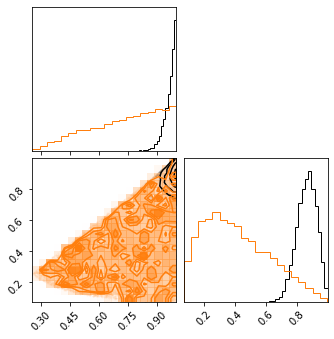

In [67]:
fg = corner.corner(smp.numpy())
fg = corner.corner(plotsamp, color = "C1",fig=fg)

In [590]:
np.min(plotsamp[:,1]/plotsamp[:,0])

0.07392072880901458

In [591]:
np.min(bsamp["mass_2"]/bsamp["mass_1"])

0.1252132714612926

In [68]:
m1,m2,mr,ch,cost = jcm.get_cost(dist, plotsamp.astype(np.float32))

(10000, 2)
(0, 2)


In [70]:
inds = np.where(np.isinf(cost.numpy()[:,0]))[0]

In [71]:
len(inds)

0

In [24]:
bilby_prior4['mass_1'].ln_prob(smp)

array([[-inf, -inf],
       [-inf, -inf],
       [-inf, -inf],
       ...,
       [-inf, -inf],
       [-inf, -inf],
       [-inf, -inf]])

In [ ]:
.ipynb_checkpoints/

In [596]:
0.01616244/0.90254927

0.017907543152741123

In [597]:
m1.numpy()[inds]

array([], shape=(0, 1), dtype=float32)

In [286]:
m2.numpy()[inds]

array([[0.03291061],
       [0.0386772 ],
       [0.04552321],
       ...,
       [0.01329963],
       [0.05408768],
       [0.02499961]], dtype=float32)

In [25]:
m1s = m1.numpy()[inds]*(bilby_prior4['mass_1'].maximum - bilby_prior4['mass_1'].minimum) + bilby_prior4['mass_1'].minimum
m2s = m2.numpy()[inds]*(bilby_prior4['mass_2'].maximum - bilby_prior4['mass_2'].minimum) + bilby_prior4['mass_2'].minimum

In [312]:
bsamp.keys()

dict_keys(['mass_1', 'mass_2', 'luminosity_distance', 'dec', 'ra', 'theta_jn', 'psi', 'phase', 'a_1', 'a_2', 'tilt_1', 'tilt_2', 'phi_12', 'phi_jl'])

In [288]:
np.max(m2s/m1s)

0.2306239

In [55]:
allm1s = m1.numpy()*(bilby_prior4['mass_1'].maximum - bilby_prior4['mass_1'].minimum) + bilby_prior4['mass_1'].minimum
allm2s = m2.numpy()*(bilby_prior4['mass_2'].maximum - bilby_prior4['mass_2'].minimum) + bilby_prior4['mass_2'].minimum

In [56]:
allm1s

array([[43.75299 ],
       [79.3188  ],
       [93.91171 ],
       ...,
       [51.656216],
       [85.30221 ],
       [45.883156]], dtype=float32)

In [57]:
prs = bilby_prior4['mass_1'].ln_prob(allm1s)

(array([    0.,     0.,     0.,     0.,     0., 10000.,     0.,     0.,
            0.,     0.]),
 array([-5.05387689, -4.95387689, -4.85387689, -4.75387689, -4.65387689,
        -4.55387689, -4.45387689, -4.35387689, -4.25387689, -4.15387689,
        -4.05387689]),
 <BarContainer object of 10 artists>)

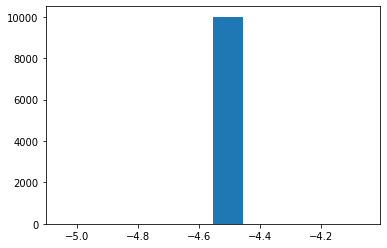

In [58]:
fig, ax = plt.subplots()
ax.hist(prs)

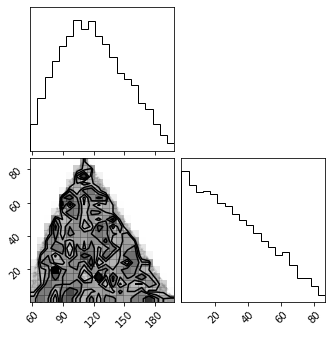

In [267]:
t_samp = np.array([bsamp["mass_1"] + bsamp["mass_2"], bsamp["mass_1"] - bsamp["mass_2"]]).T
fig = corner.corner(t_samp)

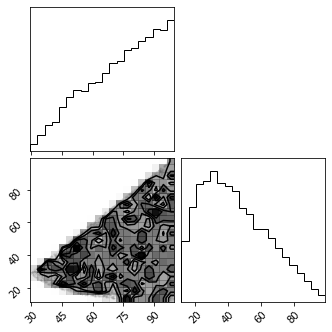

In [264]:
t_samp = np.array([bsamp["mass_1"], bsamp["mass_2"]]).T
fig = corner.corner(t_samp)

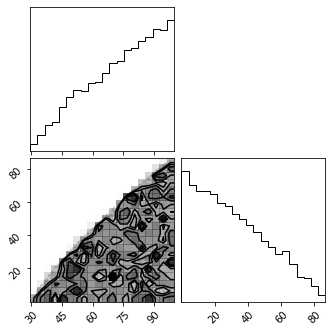

In [295]:
t_samp = np.array([bsamp["mass_1"], (bsamp["mass_1"] - bsamp["mass_2"])]).T
fig = corner.corner(t_samp)

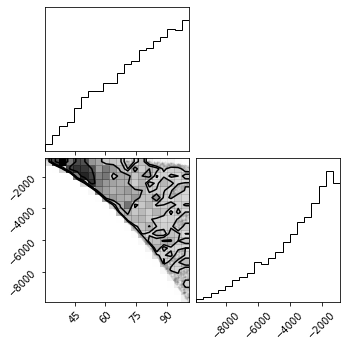

In [313]:
t_samp = np.array([1 + bsamp["mass_1"], (1 - bsamp["mass_1"])*(1+ bsamp["mass_2"])]).T
fig = corner.corner(t_samp)

In [ ]:
((bilby_prior4['mass_1'].maximum - bsamp["mass_1"])/bilby_prior4['mass_1'].maximum)

In [ ]:
class JointMRChirpmassM1M2:

    def __init__(self, pars, config):
        """                                                                                                                                
        Joint distribution for Chirpmass and symetric mas ratio                                                                            
        """
        self.name = "JointChirpmassMRM1M2"
        self.config = config
        self.pars = pars
        if self.pars[0] == "mass_2":
            self.order_flipped = True
        elif self.pars[0] == "mass_1":
            self.order_flipped = False

        self.num_pars = len(self.pars)
        if self.num_pars != 2:
            raise Exception("Please only use two variables for JointM1M2")
        self.num_outputs = [self.num_pars,self.num_pars]
        self.get_cost = self.cost_setup()
        self.sample = self.sample_setup()

    def Mconstrainm1(self, chirp_norm, m):
        """Contraint for the chirp mass based on maxmium mass of m1                                                                         
        """
        chirp = chirp_norm*(self.config["bounds"]["chirp_mass_max"] - self.config["bounds"]["chirp_mass_min"]) + self.config["bounds"]["chirp_mass_min"]
        num = (q*m*m)**(3./5.)
        den = (m*(1 + q))**(1./5.)
        chirpmass = num/den
        inds = tf.where(chirpmass > self.config["bounds"]["chirp_mass_max"])
        print(inds.shape)
        if inds.shape[0] is not None:
            updates = tf.ones(inds.shape[0], dtype=tf.float32)*np.float32(self.config["bounds"]["chirp_mass_max"])
            chirpmass = tf.tensor_scatter_nd_update(chirpmass, inds, updates)
        return (chirpmass - self.config["bounds"]["chirp_mass_min"])/(self.config["bounds"]["chirp_mass_max"] - self.config["bounds"]["chirp_mass_min"])

    def Mconstrainm2(self, q_norm, m):
        """Contraint for the chirp mass based on minimum mass of m2"""
        q = q_norm*(self.config["bounds"]["mass_ratio_max"] - self.config["bounds"]["mass_ratio_min"]) + self.config["bounds"]["mass_ratio_min"]
        num = ((1/q)*m*m)**(3./5.)
        den = (m*(1 + 1/q))**(1./5.)
        chirpmass = num/den
        inds = tf.where(chirpmass < self.config["bounds"]["chirp_mass_min"])
        print(inds.shape)
        if inds.shape[0] is not None:
            updates = tf.ones(inds.shape[0], dtype=tf.float32)*np.float32(self.config["bounds"]["chirp_mass_min"])
            chirpmass = tf.tensor_scatter_nd_update(chirpmass, inds, updates)
        return (chirpmass  - self.config["bounds"]["chirp_mass_min"])/(self.config["bounds"]["chirp_mass_max"] - self.config["bounds"]["chirp_mass_min"])
    
    def get_distribution(self, mean, logvar, ramp = 1.0):
        # this is not working yet                                                                                                           
        mean_q, mean_cm = tf.split(mean, num_or_size_splits=2, axis=1)
        logvarq, logvarcm = tf.split(logvar, num_or_size_splits=2, axis=1)

        joint = tfp.distributions.JointDistributionSequential([
            tfp.distributions.TruncatedNormal(
                loc=tf.cast(mean_q,dtype=tf.float32),
                scale=tf.cast(tf.sqrt(tf.exp(logvarq)),dtype=tf.float32),
                low=0, high=1),
            lambda b0: tfp.distributions.TruncatedNormal(
                loc=tf.cast(mean_cm,dtype=tf.float32),
                scale=tf.cast(tf.sqrt(tf.exp(logvarcm)),dtype=tf.float32),
                low=self.Mconstrainm2(b0, self.config["bounds"]["mass_2_min"]),
                high=self.Mconstrainm1(b0, self.config["bounds"]["mass_1_max"])),
        ])
        return joint

    def get_networks(self,logvar_activation="none"):
        # setup network for joint sitribution                                                                                               
        mean =  tf.keras.layers.Dense(2,activation='sigmoid', use_bias = True, name="{}_mean".format(self.name))
        logvar = tf.keras.layers.Dense(2,use_bias=True, name="{}_logvar".format(self.name),activation = logvar_activation)
        return mean, logvar
    
    def component_masses_to_chirpmass_massratio(self, normed_mass_1, normed_mass_2):
        """ Convert component masses to normalised chirp mass and mass ratio"""
        mass_1 = normed_mass_1*(self.config["bounds"]["mass_1_max"] - self.config["bounds"]["mass_1_min"]) + self.config["bounds"]["mass_1_min"]
        mass_2 = normed_mass_2*(self.config["bounds"]["mass_2_max"] - self.config["bounds"]["mass_2_min"]) + self.config["bounds"]["mass_2_min"]
        chirpmass, massratio = ((mass_1*mass_2)**(0.6))/((mass_1 + mass_2)**(0.2)), mass_2/mass_1
        normed_chirpmass = (chirpmass - self.config["bounds"]["chirp_mass_min"])/(self.config["bounds"]["chirp_mass_max"] - self.config["bounds"]["chirp_mass_min"])
        normed_massratio = (massratio - self.config["bounds"]["mass_ratio_min"])/(self.config["bounds"]["mass_ratio_max"] - self.config["bounds"]["mass_ratio_min"])
        return normed_massratio, normed_chirpmass

    def chirpmass_massratio_to_component_masses(self, chirpmass, massratio):
        """ Convert component masses to normalised chirp mass and mass ratio"""
        chirpmass = chirpmass*(self.config["bounds"]["chirp_mass_max"] - self.config["bounds"]["chirp_mass_min"]) + self.config["bounds"]["chirp_mass_min"]
        massratio = massratio*(self.config["bounds"]["mass_ratio_max"] - self.config["bounds"]["mass_ratio_min"]) + self.config["bounds"]["mass_ratio_min"]
        massratio = massratio
        total_mass = chirpmass*(1+massratio)**1.2/massratio**0.6
        mass_1 = total_mass/(1+massratio)
        mass_2 = mass_1*massratio
        normed_mass_1 = (mass_1 - self.config["bounds"]["mass_1_min"])/(self.config["bounds"]["mass_1_max"] - self.config["bounds"]["mass_1_min"])
        normed_mass_2 = (mass_2 - self.config["bounds"]["mass_2_min"])/(self.config["bounds"]["mass_2_max"] - self.config["bounds"]["mass_2_min"])
        return normed_mass_1, normed_mass_2
    
    def cost_setup(self):
        if self.order_flipped:
            def get_cost(dist, x):
                # reverse order of true parmaeters to estimate logprob                                                                      
                x2, x1 = tf.split(x, num_or_size_splits=2, axis=1)
                normed_massratio, normed_chirpmass = self.component_masses_to_chirpmass_massratio(x1,x2)
                #return -1.0*tf.reduce_mean(tf.reduce_sum(dist.log_prob(x1, x2),axis=1),axis=0)
                return x1,x2,massratio,chirpmass,dist.log_prob(normed_massratio, normed_chirpmass)
        else:
            def get_cost(dist, x):
                x1, x2 = tf.split(x, num_or_size_splits=2, axis=1)
                normed_massratio, normed_chirpmass = self.component_masses_to_chirpmass_massratio(x1,x2)
                #return -1.0*tf.reduce_mean(tf.reduce_sum(dist.log_prob(x1, x2),axis=1),axis=0)
                return x1,x2,normed_massratio,normed_chirpmass,dist.log_prob(normed_massratio, normed_chirpmass)

        return get_cost

    def sample_setup(self):
        if self.order_flipped:
            # reverse order of samples based on inputs                                                                                      
            def sample(dist, max_samples):
                # transpose amd squeeze to get [samples, parameters]                                                                        
                massratio, chirpmass =  tf.split(tf.squeeze(tf.transpose(dist.sample(), [1, 0, 2]), 2), num_or_size_splits=2, axis=1)
                mass_1, mass_2 = self.chirpmass_massratio_to_component_masses(chirpmass, massratio)
                return chirpmass, massratio,tf.concat([mass_1,mass_2], axis = 1)
        else:
            def sample(dist, max_samples):
                massratio, chirpmass =  tf.split(tf.squeeze(tf.transpose(dist.sample(), [1, 0, 2]), 2), num_or_size_splits=2, axis=1)
                mass_1, mass_2 = self.chirpmass_massratio_to_component_masses(chirpmass, massratio)
                return chirpmass, massratio, tf.concat([mass_1,mass_2], axis = 1)
        return sample